In [92]:
import os
from dataclasses import dataclass

import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio
from tqdm import tqdm
import pandas as pd

In [2]:
matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

In [3]:
torch.random.manual_seed(0)
device = torch.device("cuda:4")

In [6]:
wav_file = "/mnt/raid0/siqi/datasets/covost2/en/16kHz/common_voice_en_96413.wav"

In [5]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_LARGE_LV60K_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_large_lv60k_asr_ls960.pth" to /home/siqi/.cache/torch/hub/checkpoints/wav2vec2_fairseq_large_lv60k_asr_ls960.pth


  0%|          | 0.00/1.18G [00:00<?, ?B/s]

In [8]:
with torch.inference_mode():
    waveform, _ = torchaudio.load(wav_file)
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)
emission = emissions[0].cpu().detach()

('<s>', '<pad>', '</s>', '<unk>', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


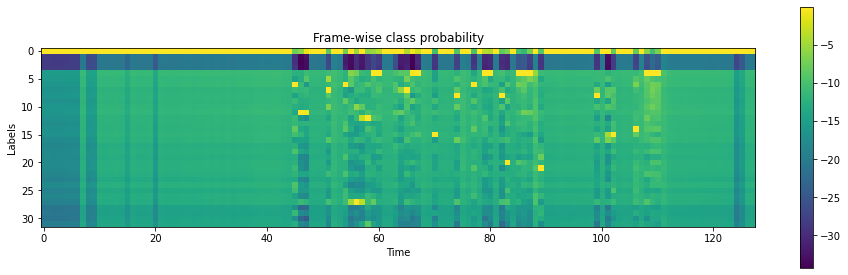

In [11]:
print(labels)
plt.imshow(emission.T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

In [12]:
transcript = "THAT'S|A|LOT|OF|GOLD"
dictionary = {c: i for i, c in enumerate(labels)}
tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))

[('T', 6), ('H', 11), ('A', 7), ('T', 6), ("'", 27), ('S', 12), ('|', 4), ('A', 7), ('|', 4), ('L', 15), ('O', 8), ('T', 6), ('|', 4), ('O', 8), ('F', 20), ('|', 4), ('G', 21), ('O', 8), ('L', 15), ('D', 14)]


In [13]:
def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    # Trellis has extra diemsions for both time axis and tokens.
    # The extra dim for tokens represents <SoS> (start-of-sentence)
    # The extra dim for time axis is for simplification of the code.
    trellis = torch.full((num_frame + 1, num_tokens + 1), -float("inf"))
    trellis[:, 0] = 0
    for t in range(num_frame):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens],
        )
    return trellis


trellis = get_trellis(emission, tokens)

In [15]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    # Note:
    # j and t are indices for trellis, which has extra dimensions
    # for time and tokens at the beginning.
    # When referring to time frame index `T` in trellis,
    # the corresponding index in emission is `T-1`.
    # Similarly, when referring to token index `J` in trellis,
    # the corresponding index in transcript is `J-1`.
    j = trellis.size(1) - 1
    t_start = torch.argmax(trellis[:, j]).item()

    path = []
    for t in range(t_start, 0, -1):
        # 1. Figure out if the current position was stay or change
        # Note (again):
        # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
        # Score for token staying the same from time frame J-1 to T.
        stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
        # Score for token changing from C-1 at T-1 to J at T.
        changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]]

        # 2. Store the path with frame-wise probability.
        prob = emission[t - 1, tokens[j - 1] if changed > stayed else 0].exp().item()
        # Return token index and time index in non-trellis coordinate.
        path.append(Point(j - 1, t - 1, prob))

        # 3. Update the token
        if changed > stayed:
            j -= 1
            if j == 0:
                break
    else:
        raise ValueError("Failed to align")
    return path[::-1]


path = backtrack(trellis, emission, tokens)
print(path)

[Point(token_index=0, time_index=45, score=0.9989526271820068), Point(token_index=1, time_index=46, score=0.9969344139099121), Point(token_index=1, time_index=47, score=0.39028412103652954), Point(token_index=1, time_index=48, score=0.9998880624771118), Point(token_index=1, time_index=49, score=0.9998891353607178), Point(token_index=1, time_index=50, score=0.9998946189880371), Point(token_index=2, time_index=51, score=0.9920342564582825), Point(token_index=2, time_index=52, score=0.9996565580368042), Point(token_index=2, time_index=53, score=0.9998213648796082), Point(token_index=3, time_index=54, score=0.9985499978065491), Point(token_index=3, time_index=55, score=0.9914244413375854), Point(token_index=4, time_index=56, score=0.9906483292579651), Point(token_index=4, time_index=57, score=0.9299869537353516), Point(token_index=5, time_index=58, score=0.9959588646888733), Point(token_index=6, time_index=59, score=0.9945911169052124), Point(token_index=6, time_index=60, score=0.024770667

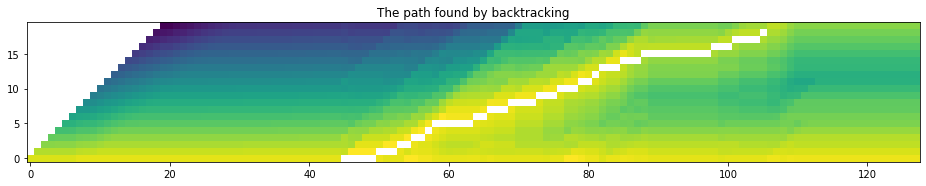

In [16]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path[1:, 1:].T, origin="lower")


plot_trellis_with_path(trellis, path)
plt.title("The path found by backtracking")
plt.show()

In [17]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

T	(1.00): [   45,    46)
H	(0.88): [   46,    51)
A	(1.00): [   51,    54)
T	(0.99): [   54,    56)
'	(0.96): [   56,    58)
S	(1.00): [   58,    59)
|	(0.84): [   59,    65)
A	(0.73): [   65,    67)
|	(0.98): [   67,    70)
L	(1.00): [   70,    74)
O	(1.00): [   74,    77)
T	(0.67): [   77,    80)
|	(0.99): [   80,    82)
O	(1.00): [   82,    83)
F	(0.67): [   83,    86)
|	(0.66): [   86,    89)
G	(1.00): [   89,    99)
O	(1.00): [   99,   102)
L	(1.00): [  102,   106)
D	(1.00): [  106,   107)


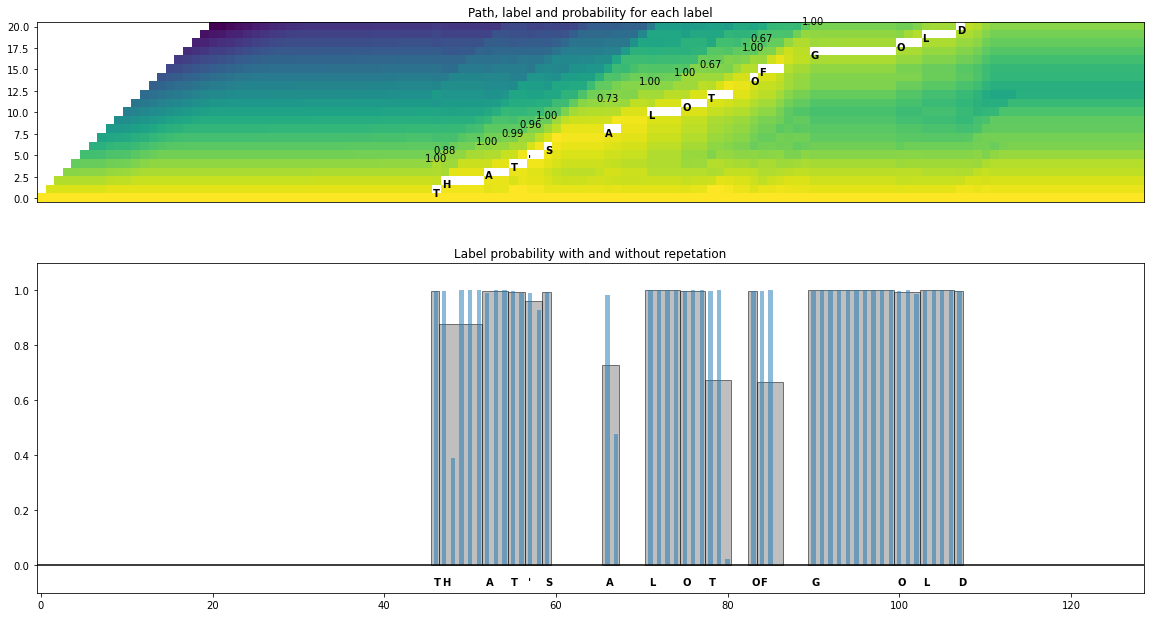

In [18]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower")
    ax1.set_xticks([])

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start + 0.7, i + 0.3), weight="bold")
            ax1.annotate(f"{seg.score:.2f}", (seg.start - 0.3, i + 4.3))

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07), weight="bold")
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(-0.1, 1.1)


plot_trellis_with_segments(trellis, segments, transcript)
plt.tight_layout()
plt.show()

In [19]:
# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

THAT'S	(0.95): [   45,    59)
A	(0.73): [   65,    67)
LOT	(0.90): [   70,    80)
OF	(0.75): [   82,    86)
GOLD	(1.00): [   89,   107)


In [59]:
word_segments[0]

THAT'S	(0.95): [   45,    59)

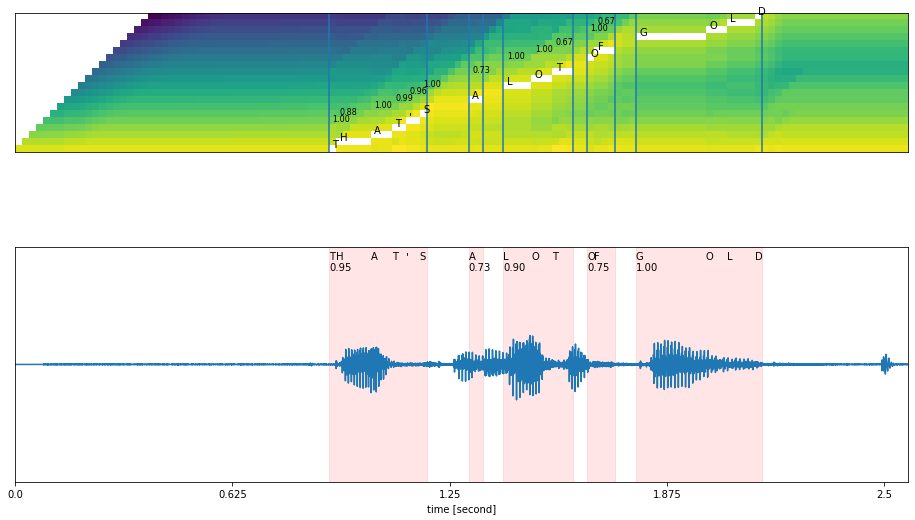

In [20]:
def plot_alignments(trellis, segments, word_segments, waveform):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))

    ax1.imshow(trellis_with_path[1:, 1:].T, origin="lower")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvline(word.start - 0.5)
        ax1.axvline(word.end - 0.5)

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i + 0.3))
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 4), fontsize=8)

    # The original waveform
    ratio = waveform.size(0) / (trellis.size(0) - 1)
    ax2.plot(waveform)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, alpha=0.1, color="red")
        ax2.annotate(f"{word.score:.2f}", (x0, 0.8))

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, 0.9))
    xticks = ax2.get_xticks()
    plt.xticks(xticks, xticks / bundle.sample_rate)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    ax2.set_ylim(-1.0, 1.0)
    ax2.set_xlim(0, waveform.size(-1))


plot_alignments(
    trellis,
    segments,
    word_segments,
    waveform[0],
)
plt.show()


# A trick to embed the resulting audio to the generated file.
# `IPython.display.Audio` has to be the last call in a cell,
# and there should be only one call par cell.
def display_segment(i):
    ratio = waveform.size(1) / (trellis.size(0) - 1)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    filename = f"_assets/{i}_{word.label}.wav"
    torchaudio.save(filename, waveform[:, x0:x1], bundle.sample_rate)
    print(f"{word.label} ({word.score:.2f}): {x0 / bundle.sample_rate:.3f} - {x1 / bundle.sample_rate:.3f} sec")
    return IPython.display.Audio(filename)

# CTC forced align MuST-C

In [109]:
import re

import soundfile

from examples.speech_to_text.data_utils import load_df_from_tsv

In [56]:
mustc_root = '/mnt/raid0/siqi/datasets/must-c'
train_df = load_df_from_tsv(os.path.join(mustc_root, 'en-de/train_wave.tsv'))

In [49]:
noises = ['(Applause)', '(Audience)', '(Audio)', '(Beat)', '(Beatboxing)', '(Beep)', '(Beeps)', '(Cheering)', '(Cheers)', '(Claps)', '(Clicking)', '(Clunk)', '(Coughs)', \
    '(Drums)', '(Explosion)', '(Gasps)', '(Guitar)', '(Honk)', '(Laugher)', '(Laughing)', '(Laughs)', '(Laughter)', '(Mumbling)', '(Music)', '(Noise)', '(Recording)', \
    '(Ringing)', '(Shouts)', '(Sigh)', '(Sighs)', '(Silence)', '(Singing)', '(Sings)', '(Spanish)', '(Static)', '(Tones)', '(Trumpet)', '(Video)', '(Voice-over)', \
    '(Whistle)', '(Whistling)', '(video)']

In [119]:
re.match("(.{,20}:).*", 'AG:1').group(1)

'AG:'

In [132]:
def clean(text):
    prefix = re.match("(.{,20}:).*", text)
    if prefix is not None:
        text = text[len(prefix.group(1)):]
    for noise in noises:
        text = text.replace(noise, '')
    tokens = []
    for c in text:
        if c.isalpha():
            if c.upper() in dictionary:
                tokens.append(c.upper())
        elif c == "'":
            tokens.append(c)
        else:
            tokens.append('|')
    transcript = []
    for c in tokens:
        if c == '|':
            if len(transcript) > 0 and transcript[-1] != '|':
                transcript.append(c)
        else:
            transcript.append(c)
    if len(transcript) > 0 and transcript[-1] == '|':
        transcript.pop()
    
    return ''.join(transcript)

In [133]:
mismatch_df = pd.DataFrame(columns=train_df.columns)
iterator = tqdm(train_df.iterrows(), total=train_df.shape[0], desc='0 mismatch found')
for _, row in iterator:
    splits = row['audio'].split(':')
    ori_start, ori_duration = splits[-2:]
    ori_start, ori_duration = int(ori_start), int(ori_duration)
    
    wav_file = os.path.join(mustc_root, ''.join(splits[:-2]))
    with torch.inference_mode():
        waveform, _ = torchaudio.load(wav_file, \
            frame_offset=max(ori_start - 3 * 16000, 0), num_frames=ori_duration + 6 * 16000)
        emissions, _ = model(waveform.to(device))
        emissions = torch.log_softmax(emissions, dim=-1)
    emission = emissions[0].cpu().detach()

    transcript = clean(row['src_text'])
    if transcript == '':
        continue
    tokens = [dictionary[c] for c in transcript]
    trellis = get_trellis(emission, tokens)
    path = backtrack(trellis, emission, tokens)
    segments = merge_repeats(path)
    word_segments = merge_words(segments)

    ratio = waveform.size(1) / (trellis.size(0) - 1)
    start = ratio * word_segments[0].start
    end = ratio * word_segments[-1].end

    if start < 2.75 * 16000 or end > waveform.size(1) - 2.75 * 16000:
        mismatch_df = mismatch_df.append(row, ignore_index=True)
        iterator.set_description('{} mismatch found'.format(mismatch_df.shape[0]))

14838 mismatch found:  69%|██████▉   | 158260/229657 [3:30:19<1:34:53, 12.54it/s]


KeyboardInterrupt: 

In [126]:
string = '<table>\n'
string += '\t<tr>\n\t\t<th>Transcript</th>\n\t\t<th>Translation</th>\n\t\t<th>Source Audio</th>\n\t</tr>\n'
for i in tqdm(range(mismatch_df.shape[0])):
    match = re.match('(.*):(\d+):(\d+)', mismatch_df['audio'][i])
    wav = os.path.join(mustc_root, match.group(1))
    speech_array, sampling_rate = soundfile.read( wav )
    speech_array = speech_array[int(match.group(2)):int(match.group(2))+int(match.group(3))]
    soundfile.write('resources/train-mismatch/audio_{}.wav'.format(i), speech_array, 16000)
    string += '\t<tr>\n\t\t<td>{}</td>\n\t\t<td>{}</td>\n\t\t<td>{}</td>\n\t</tr>\n'.format(\
        mismatch_df['src_text'][i], mismatch_df['tgt_text'][i], \
        '<audio controls><source src="train-mismatch/audio_{}.wav" type="audio/wav"></audio>'.format(i))
string += '</table>'

100%|██████████| 21/21 [00:07<00:00,  2.67it/s]


In [134]:
with open('train-mismatch.html', 'w') as w:
    w.write(string)